# **Trabalho Prático 2 - Cálculo Numérico - SME0104**

---
Amanda Caroline de Oliveira Pires - 12559090


### **Bibliotecas e Funções**

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import barycentric_interpolate, KroghInterpolator
from scipy.optimize import curve_fit
import math

### **Decomposição em Valores Singulares (SVD)**

**a)** Escreva um código implementando o método de Francis usando a função numpy.linalg.qr para obter as decomposições QR necessárias.

In [122]:
# Método de Francis

def francis_method(A, max_iterations=1000, tolerance=1e-6):
    n = A.shape[0]
    B = A.copy()
    Q = np.eye(n)

    for k in range(max_iterations):
        Qk, Rk = np.linalg.qr(B)
        B = Rk @ Qk
        Q = Q @ Qk

        off_diag_sum = np.sum(np.abs(B[np.triu_indices(n, 1)]))
        if off_diag_sum < tolerance:
            break

    autovalores = np.diag(B)
    autovetores  = Q

    return autovalores, autovetores

# Exemplo
A = np.array([[6, 2, 1],
              [2, 5, 1],
              [1, 1, 1]])

autovalores, autovetores  = francis_method(A)
print("Autovalores:", autovalores)
print('')
print("Autovetores:\n", autovetores )

Autovalores: [7.84947157 3.4486456  0.70188282]

Autovetores:
 [[-0.76726057  0.63006424 -0.11970916]
 [-0.6090451  -0.77430555 -0.17179926]
 [-0.20093603 -0.05890652  0.97783165]]


**b)** Usando a rotina implementada para o método de Francis, escreva um código que retorne a decomposição SVD de uma matriz qualquer Am×n.

In [123]:
def svd_decomposition(A):
    m, n = A.shape
    if m < n:
        A_padded = np.pad(A, ((0, n-m), (0, 0)), mode='constant')
        autovalores, autovetores = francis_method(A_padded.T @ A_padded)
        autovalores = np.sqrt(autovalores[:m])
        V = autovetores[:, :m]
        U = A_padded @ V / autovalores
    else:
        autovalores, autovetores = francis_method(A @ A.T)
        autovalores = np.sqrt(autovalores)
        U = autovetores
        V = A.T @ U / autovalores[:, np.newaxis]

    return U, autovalores, V.T

U, sigma, V = svd_decomposition(A)
print("U:\n", U)
print('')
print("Sigma:\n", sigma)
print('')
print("V:\n", V)

U:
 [[-0.76726049  0.63006433 -0.11970916]
 [-0.6090452  -0.77430547 -0.17179926]
 [-0.20093604 -0.0589065   0.97783165]]

Sigma:
 [7.84947157 3.4486456  0.70188282]

V:
 [[-0.76726048 -1.38624943 -2.24715818]
 [ 0.27681718 -0.77430548 -0.28943241]
 [-0.01070413 -0.03496531  0.97783165]]


**c)** Podemos armazenar uma imagem em uma matriz Am×n. Toda imagem consiste em um conjunto de pixels que são os blocos de construção dessa imagem. Cada pixel representa a cor ou a intensidade da luz em um local específico na imagem. Em uma imagem em escala de cinza em formato PNG, cada pixel tem um valor entre 0 e
1, em que 0 corresponde ao preto e 1 corresponde ao branco. Assim, uma imagem em escala de cinza com m×n pixels pode ser armazenada em uma matriz m × n com valores entre 0 e 1. Use a função imread() da biblioteca Matplotlib do Python para carregar uma imagem de uma foto pessoal em escala de cinza. Depois, use as
decomposições SVD numpy.linalg.svd e a implementada no item 2) para comprimir a imagem, representando-a por k (k < min{m, n}) valores singulares, isto é, troque a matriz A por Ak = U[:, : k] ∗ Σ[: k, : k] ∗ V T[: k, :]. Plote a imagem original e a imagem 50% e 70% comprimida e compare os resultados. Para tal, use a função imshow(), também da biblioteca Matplotlib.

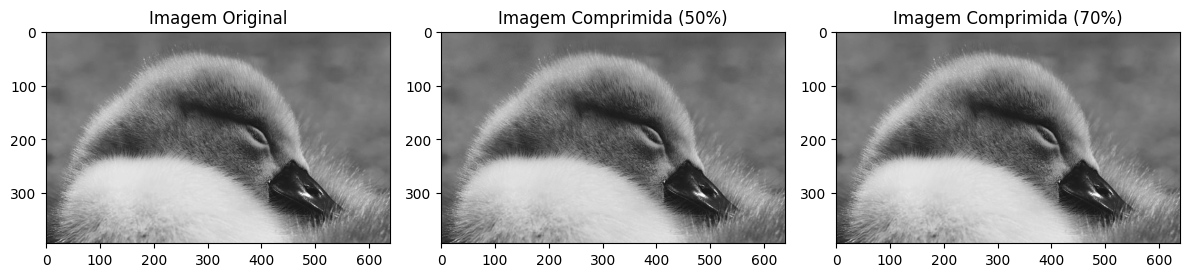

In [124]:
# Carregando imagem
imagem = plt.imread('/content/cygnet-g1eb444562_640.jpg')

# Verificando a forma da imagem
if len(imagem.shape) > 2:
    # Converter imagem colorida para escala de cinza
    imagem = np.mean(imagem, axis=2)

# Obter as dimensões da imagem
m, n = imagem.shape

# Decomposição SVD
U, sigma, Vt = np.linalg.svd(imagem)

# Definindo a quantidade de valores singulares a serem mantidos para compressão
k_50_percent = int(min(m, n) * 0.5)  # 50% de compressão
k_70_percent = int(min(m, n) * 0.7)  # 70% de compressão

# Comprimindo a imagemm usando os valores singulares selecionados
compressed_imagem_50_percent = U[:, :k_50_percent] @ np.diag(sigma[:k_50_percent]) @ Vt[:k_50_percent, :]
compressed_imagem_70_percent = U[:, :k_70_percent] @ np.diag(sigma[:k_70_percent]) @ Vt[:k_70_percent, :]

# Plotar as imagemns original e comprimidas
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(imagem, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(compressed_imagem_50_percent, cmap='gray')
plt.title('Imagem Comprimida (50%)')
plt.subplot(1, 3, 3)
plt.imshow(compressed_imagem_70_percent, cmap='gray')
plt.title('Imagem Comprimida (70%)')
plt.tight_layout()
plt.show()

A diferença entre as imagens é imperceptível, logo utilizaremos o Erro Quadrático Médio para avaliar a diferença entre as imagens. Quanto mais próximo de zero, significa que menor é diferença.

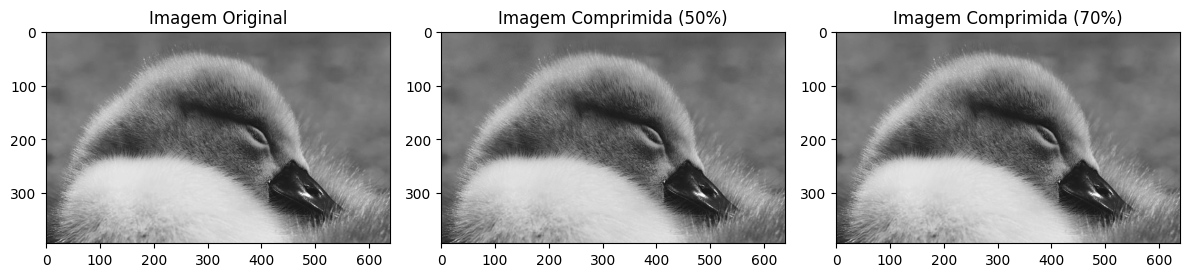

Erro Quadrático Médio compressão em 50%: 1.6457863358548226
Erro Quadrático Médio compressão em 70%: 0.5453736464230559


In [125]:
# Função para calcular o Erro Quadrático Médio (RMSE)
def calcular_rmse(imagem1, imagem2):
    diferenca = imagem1 - imagem2
    mse = np.mean(diferenca**2)
    rmse = np.sqrt(mse)
    return rmse

# Calcular o RMSE entre a imagem original e as imagens comprimidas
rmse_50_percent = calcular_rmse(imagem, compressed_imagem_50_percent)
rmse_70_percent = calcular_rmse(imagem, compressed_imagem_70_percent)

# Plotar as imagens original e comprimidas
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(imagem, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(compressed_imagem_50_percent, cmap='gray')
plt.title('Imagem Comprimida (50%)')

plt.subplot(1, 3, 3)
plt.imshow(compressed_imagem_70_percent, cmap='gray')
plt.title('Imagem Comprimida (70%)')
plt.tight_layout()
plt.show()
print('Erro Quadrático Médio compressão em 50%:', rmse_50_percent)
print('Erro Quadrático Médio compressão em 70%:', rmse_70_percent)

Como o erro quadrático médio da imagem comprimida em 70% foi menor, podemos concluir que a compressão em 70% preservou a maior parte das informações importantes da imagem original.

Compressão de Imagem com o método de Francis e decomposição SVD:

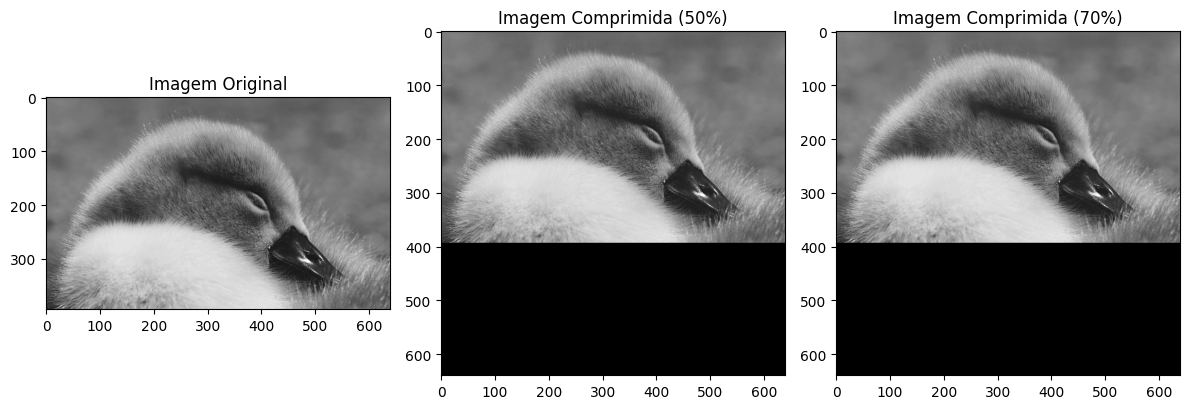

In [126]:
def francis_algorithm(A, max_iterations=1000, tolerance=1e-3):
    n = A.shape[0]
    B = A.copy()
    Q = np.eye(n)

    for k in range(max_iterations):
        Qk, Rk = np.linalg.qr(B)
        B = Rk @ Qk
        Q = Q @ Qk

        off_diag_sum = np.sum(np.abs(B[np.triu_indices(n, 1)]))
        if off_diag_sum < tolerance:
            break

    eigenvalues = np.diag(B)
    eigenvectors = Q

    return eigenvalues, eigenvectors

def svd_decomposition(A):
    m, n = A.shape
    if m < n:
        # Pad the matrix with zeros
        A_padded = np.pad(A, ((0, n-m), (0, 0)), mode='constant')
        eigenvalues, eigenvectors = francis_algorithm(A_padded.T @ A_padded)
        eigenvalues = np.sqrt(eigenvalues[:m])
        V = eigenvectors[:, :m]
        U = A_padded @ V / eigenvalues
    else:
        eigenvalues, eigenvectors = francis_algorithm(A @ A.T)
        eigenvalues = np.sqrt(eigenvalues)
        U = eigenvectors
        V = A.T @ U / eigenvalues[:, np.newaxis]

    return U, eigenvalues, V.T

# Carregar a imagem em escala de cinza usando imread()
image = plt.imread('/content/cygnet-g1eb444562_640.jpg')

# Verificar a forma da imagem
if len(image.shape) > 2:
    # Converter imagem colorida para escala de cinza
    image = np.mean(image, axis=2)

# Comprimir a imagem em 50% e 70%
U, sigma, V = svd_decomposition(image)
k_50_percent = int(min(U.shape[1], V.shape[0]) * 0.5)  # 50% de compressão
k_70_percent = int(min(U.shape[1], V.shape[0]) * 0.7)  # 70% de compressão
compressed_image_50_percent = U[:, :k_50_percent] @ np.diag(sigma[:k_50_percent]) @ V[:k_50_percent, :]
compressed_image_70_percent = U[:, :k_70_percent] @ np.diag(sigma[:k_70_percent]) @ V[:k_70_percent, :]

# Plotar as imagens original e comprimidas
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(compressed_image_50_percent, cmap='gray')
plt.title('Imagem Comprimida (50%)')

plt.subplot(1, 3, 3)
plt.imshow(compressed_image_70_percent, cmap='gray')
plt.title('Imagem Comprimida (70%)')

plt.tight_layout()
plt.show()

Por esse método é clara a diferença nas imagens comprimidas para a imagem original.

### **Interpolação**

**a)** Implemente a interpolação de Lagrange e de Newton.

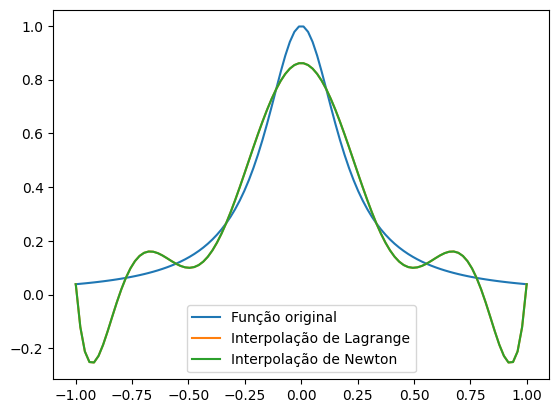

In [127]:
# Definindo a função

def f(t):
    return 1 / (1 + 25 * t**2)

# Interpolação de Lagrange
def lagrange_interpolation(x, y, t):
    n = len(x)
    result = 0
    for i in range(n):
        term = y[i]
        for j in range(n):
            if j != i:
                term = term * (t - x[j]) / (x[i] - x[j])
        result += term
    return result

# Interpolação de Newton
def newton_interpolation(x, y, t):
    n = len(x)
    divided_diff = np.zeros((n, n))
    divided_diff[:,0] = y
    for j in range(1, n):
        for i in range(n-j):
            divided_diff[i][j] = (divided_diff[i+1][j-1] - divided_diff[i][j-1]) / (x[i+j] - x[i])
    result = divided_diff[0][n-1]
    for i in range(n-2, -1, -1):
        result = result * (t - x[i]) + divided_diff[0][i]
    return result

x = np.linspace(-1, 1, 10) # 10 pontos
y = f(x)
t = np.linspace(-1, 1, 100)

#print(lagrange_interpolation(x, y, t))
#print(newton_interpolation(x, y, t))

plt.plot(t, f(t), label='Função original')
plt.plot(t, [lagrange_interpolation(x, y, ti) for ti in t], label='Interpolação de Lagrange')
plt.plot(t, [newton_interpolation(x, y, ti) for ti in t], label='Interpolação de Newton')
plt.legend()
plt.show()

É possível perceber que a interpolação de Lagrange e de Newton estão praticamente iguais.

**b)** Usando 11 pontos igualmente espaçados dentro do intervalo dado, calcule as interpolações de Lagrange e Newton com o código implementado no item anterior.

Interpolação de Lagrange: [0.038461538461538464, 1.2388266194220503, 1.811077389442583, 1.958796537737546, 1.8373893929159237, 1.5627589810227736, 1.2187901856843766, 0.8637649349530233, 0.5358214931969073, 0.2575624986392214, 0.03990834883962901, -0.11471511154669779, -0.2097729130805137, -0.2525265007548707, -0.2523802283183918, -0.2196067232340564, -0.16439487016584955, -0.09616965736438246, -0.02313829999439747, 0.047978093610131965, 0.11206350348583989, 0.16560857437857504, 0.2066227806609944, 0.23448150180287441, 0.24972893090051496, 0.2538546025654563, 0.24905844444974087, 0.2380166197672427, 0.22365802728008097, 0.20895915127798237, 0.19676299800855704, 0.189626107739954, 0.18969608407619654, 0.19862072522176355, 0.21748866652766008, 0.2468004407683677, 0.28646802311969854, 0.33584024265372864, 0.3937509022606665, 0.45858604517080154, 0.528366529604527, 0.6008419144469408, 0.6735916091476781, 0.7441292912084929, 0.8100067355626293, 0.8689134227933751, 0.918768588406228, 0.95780

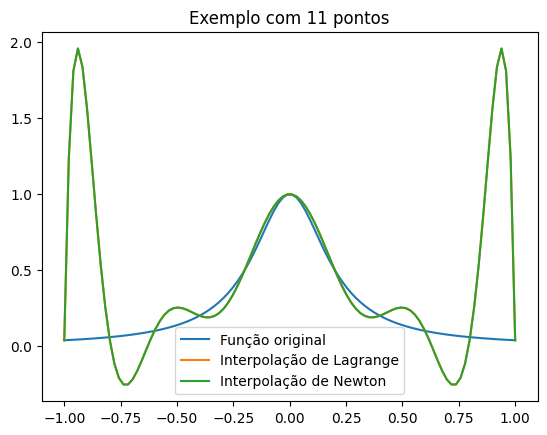

In [128]:
# Examplo com 11 pontos

x = np.linspace(-1, 1, 11)
y = f(x)
t = np.linspace(-1, 1, 100)

y_lagrange = [lagrange_interpolation(x, y, ti) for ti in t]
y_newton = [newton_interpolation(x, y, ti) for ti in t]

print('Interpolação de Lagrange:', y_lagrange)
print('Interpolação de Newton:', y_newton)
plt.plot(t, f(t), label='Função original')
plt.plot(t, [lagrange_interpolation(x, y, ti) for ti in t], label='Interpolação de Lagrange')
plt.plot(t, [newton_interpolation(x, y, ti) for ti in t], label='Interpolação de Newton')
plt.title('Exemplo com 11 pontos')
plt.legend()
plt.show()

O erro na parte central ficou menor, porém nas caldas a margem de erro aumentou muito.

**c)** Repita o processo com 21 pontos. O que acontece? Exiba o gráfico das soluções comparando com a exata.


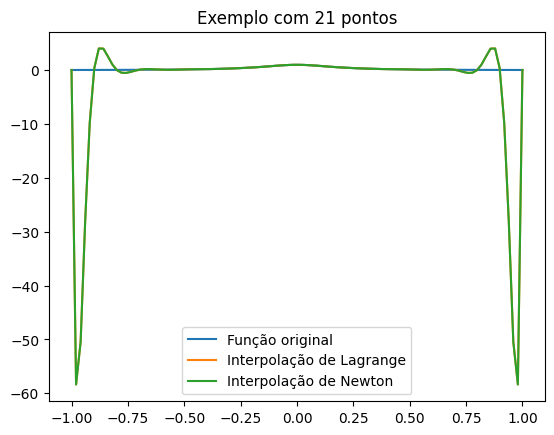

In [129]:
x = np.linspace(-1, 1, 21)
y = f(x)
t = np.linspace(-1, 1, 100)

plt.plot(t, f(t), label='Função original')
plt.plot(t, [lagrange_interpolation(x, y, ti) for ti in t], label='Interpolação de Lagrange')
plt.plot(t, [newton_interpolation(x, y, ti) for ti in t], label='Interpolação de Newton')
plt.legend()
plt.title('Exemplo com 21 pontos')
plt.show()

Mesmo aumentando o número de pontos, a margem de erro continua considerável, isso se deve ao fenômeno Runge, ou seja, não há garantias que Pn converge para f quando n → ∞, pois a interpolação polinomial de alta ordem é instável em uma
distribuição uniforme de nós.

**d)** Usando a função scipy.interpolate.interp1d calcule a interpolação usando spline linear e cúbica. Exiba os gráficos e comente as diferenças das soluções deste item para os anteriores.

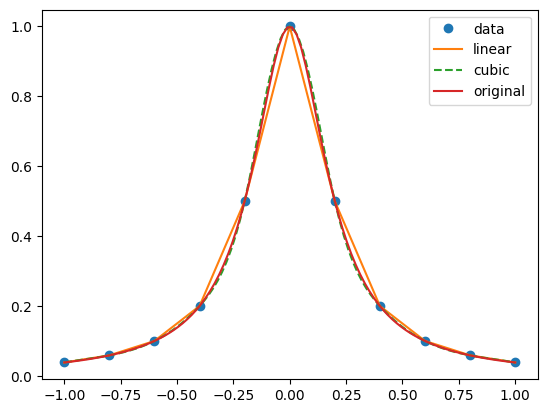

In [130]:
def f(t):
    return 1 / (1 + 25 * t**2)

x = np.linspace(-1, 1, 11)
y = f(x)

# Cria a interpolação linear e cúbica
f_linear = interp1d(x, y)
f_cubic = interp1d(x, y, kind='cubic')

# Criando os pontos para plotar as funções interpoladas
xnew = np.linspace(-1, 1, 101)
ynew_linear = f_linear(xnew)
ynew_cubic = f_cubic(xnew)

plt.plot(x, y, 'o', xnew, ynew_linear, '-', xnew, ynew_cubic, '--')
plt.plot(t, f(t), label='Função original')
plt.legend(['data', 'linear', 'cubic','original'], loc='best')
plt.show()

É notório que a interpolação utilizando a spline cúbica se aproxima melhor da função original do que a spline linear, isso se deve ao fato de que a segunda derivada da spline cúbica é contínua em todo o intervalo, enquanto que na spline linear a segunda derívada é descontínua nos nós.

**e)** Repita os itens b) e c) com nós de Chebyshev.

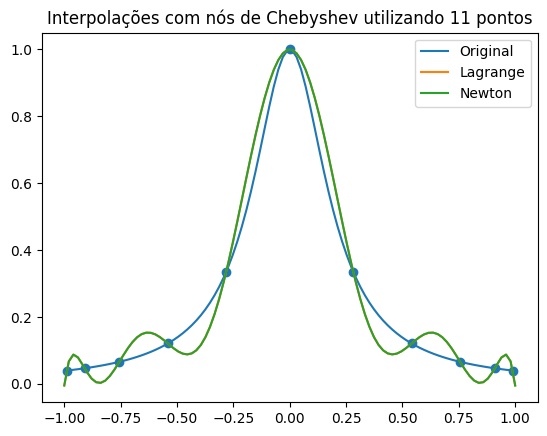

In [131]:
def f(t):
    return 1 / (1 + 25 * t**2)

# Número de pontos
n = 11

# Nós de Chebyshev
x = np.cos(np.pi * (2 * np.arange(n) + 1) / (2 * n))

# Valores da função em nós Chebyshev
y = f(x)

# Interpolação de Lagrange com nós de Chebyshev
def lagrange_interpolation(x, y, t):
    return barycentric_interpolate(x, y, t)

# Interpolação de Newton com nós de Chebyshev
def newton_interpolation(x, y, t):
    newton_interpolator = KroghInterpolator(x, y)
    return newton_interpolator(t)

t = np.linspace(-1, 1, 100)
lagrange_y = lagrange_interpolation(x, y, t)
newton_y = newton_interpolation(x, y, t)

plt.plot(t, f(t), label='Original')
plt.plot(t, lagrange_y, label='Lagrange')
plt.plot(t, newton_y, label='Newton')
plt.scatter(x, y)
plt.legend()
plt.title('Interpolações com nós de Chebyshev utilizando 11 pontos')
plt.show()

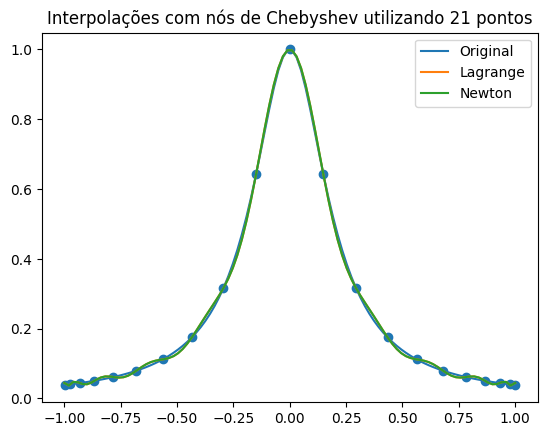

In [132]:
# Número de pontos
n = 21

# Nós de Chebyshev
x = np.cos(np.pi * (2 * np.arange(n) + 1) / (2 * n))

# Valores da função em nós Chebyshev
y = f(x)

# Interpolação de Lagrange com nós de Chebyshev
def lagrange_interpolation(x, y, t):
    return barycentric_interpolate(x, y, t)

# Interpolação de Newton com nós de Chebyshev
def newton_interpolation(x, y, t):
    newton_interpolator = KroghInterpolator(x, y)
    return newton_interpolator(t)

t = np.linspace(-1, 1, 100)
lagrange_y = lagrange_interpolation(x, y, t)
newton_y = newton_interpolation(x, y, t)

plt.plot(t, f(t), label='Original')
plt.plot(t, lagrange_y, label='Lagrange')
plt.plot(t, newton_y, label='Newton')
plt.scatter(x, y)
plt.legend()
plt.title('Interpolações com nós de Chebyshev utilizando 21 pontos')
plt.show()

Como visto, as interpolações melhoraram muito com os nós de Chebyshev em relação aos itens b) e c) nos quais não foram aplicados o método. Com 21 pontos, as interpolações de Newton e Lagrange (utilizando os nós de  Chebyshev) obtiveram uma melhor aproximação do que com 11 pontos. Isso era esperado pois ao aumentar o número de pontos, as interpolações com os nós de Chebyshev melhoram a fim de minimizar o efeito do fenômeno Runge, que é um problema que ocorre quando se tenta interpolar uma função com um polinômio de alto grau usando pontos igualmente espaçados.

### **Mínimos Quadrados**

**a)** Explique cada um dos códigos dados acima. O que está sendo calculado?

In [133]:
import numpy as np
def mmq(x,y,k):
  X = np.vander(x,k)
  A = np.transpose(X).dot(X)
  b = np.transpose(X).dot(y)
  a = np.linalg.solve(A, b)
  return a

O código acima importa a biblioteca numpy, depois cria uma função do método de mínimos quadrados (mmq) para ajustar um polinômio de grau k-1 aos pontos (x,y). A matriz **X** é criada usando a função **np.vander** que gera uma matriz de Vandermonde, a matriz **A** é calculada como o produto interno da matriz transposta de **X** com ela mesma.
O vetor **b** é calculado como o produto interno da matriz transposta de **X** com o vetor **y**. Por fim, o vetor com os coeficientes do poliômio **a** é calculado resolvendo o sistema linear:

A.a = b (Usando a função **np.linalg.solve**)

Por último a função retorna o vetor de coeficientes **a**

In [134]:
def mmqQR(x,y,k):
  X = np.vander(x,k)
  (Q,R) = np.linalg.qr(X)
  b = np.transpose(Q).dot(y)
  a = np.linalg.solve(R, b)
  return a

É criada uma função do método dos mínimos quadrados usando a **decomposição QR**, essa função recebe os argumentos **x** e **y** e o grau do polinômio **k**. A matriz **X** é criada usando a função **np.vander**, que cria uma matriz de Vandermonde, **X** é decomposta em suas componentes QR usando a função **np.linalg.qr**. O vetor **b** é calculado pelo produto interno da matriz transposta de Q com o vetor **y**. O vetor de coeficientes do polinômio **a** é calculado resolvendo:

R.a = b (usando **np.linalg.solve**)


Por fim, retorna o vetor de coeficientes **a**

**b)** Aproxime, no sentido dos mínimos quadrados, os dados do período completo, de 26 de fevereiro de 2020 a 18 de junho de 2020, por uma função g(x) = ab^x, com a, b ∈ R. Use um dos códigos dados acima.

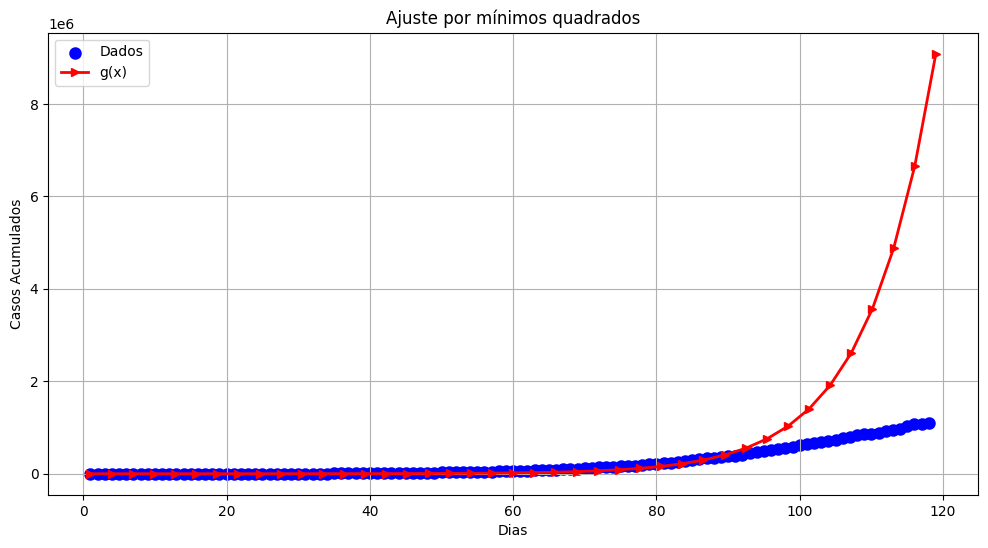

In [135]:
def mmq(x, y, k):
    X = np.vander(x, k)
    A = np.transpose(X).dot(X)
    b = np.transpose(X).dot(y)
    a = np.linalg.solve(A, b)
    return a

# Dados de casos acumulados
data = np.loadtxt('/content/casosacumuladosbrasilatuaizado.txt')

x = np.arange(1, len(data) + 1)  # tamanho dos dados
y = data # dados do arquivo

# Função ajustada
a = mmq(x, np.log(y), 2)
#print(a)


# g(x) = ab^x
g = lambda x: np.exp(a[1]) * np.exp(a[0])**x

x_cont = np.linspace(1, len(data)+1, num=41, endpoint=True)

# plot
plt.figure(figsize=(12,6))
plt.scatter(x,y,label = 'Dados',linewidth = 3,color='blue')
plt.plot(x_cont,g(x_cont),label = 'g(x)',linewidth = 2,marker='>', color = 'red')
plt.xlabel('Dias')
plt.ylabel('Casos Acumulados')
plt.title('Ajuste por mínimos quadrados')
plt.legend()
plt.grid(True)
plt.show()

**c)** Repita o ítem **b)** usando apenas os 20 primeiros dias.

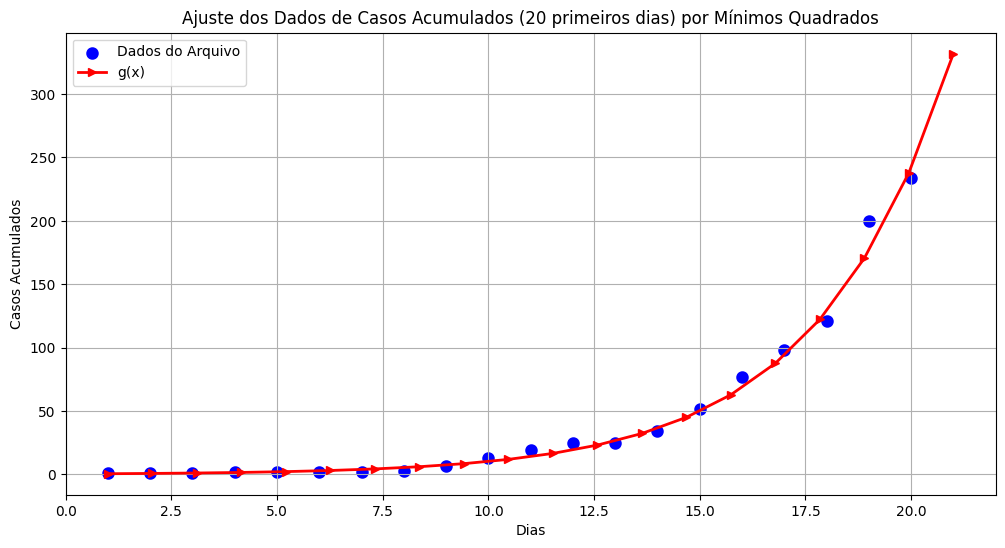

In [136]:
x = np.arange(1, 21)
y = data[:20]
#print(x)
#print(y)

# Ajuste dos dados usando a função g(x) = ab^x
a = mmq(x, np.log(y), 2)
#print(a)


# g(x) = ab^x
g = lambda x: np.exp(a[1]) * np.exp(a[0])**x

x_cont = np.linspace(1, 21, num=20, endpoint=True)

# Plot dos dados e da função ajustada
plt.figure(figsize=(12,6))
plt.scatter(x,y,label = 'Dados do Arquivo',linewidth = 3,color='blue')
plt.plot(x_cont,g(x_cont),label = 'g(x)',linewidth = 2,marker='>', color = 'red')
plt.xlabel('Dias')
plt.ylabel('Casos Acumulados')
plt.title('Ajuste dos Dados de Casos Acumulados (20 primeiros dias) por Mínimos Quadrados')
plt.grid(True)
plt.legend()
plt.show()

Se usarmos a função pronta **curve_fit**, obtemos o mesmo resultado:

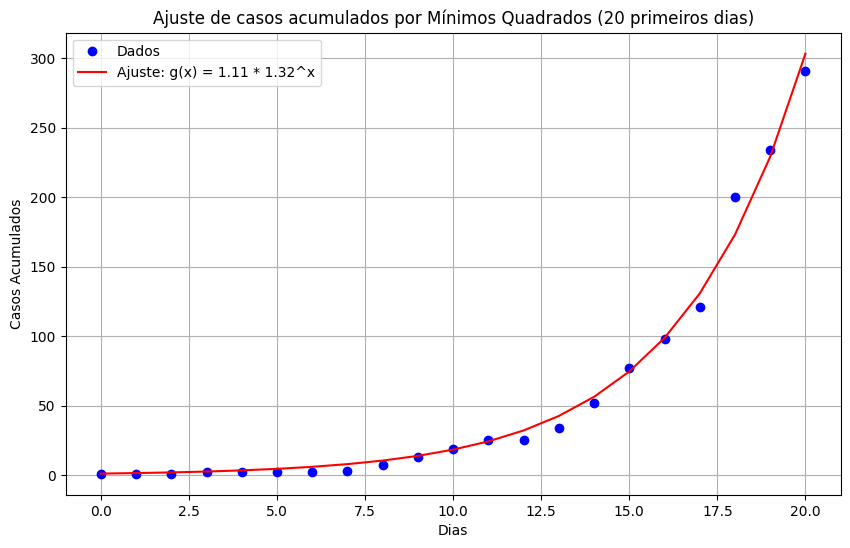

In [137]:
# Função a ser ajustada
def g(x, a, b):
    return a * b**x
x = np.arange(21)  # Apenas os 20 primeiros dias
y = data[:21]  # Apenas os 20 primeiros valores

# Ajuste não linear utilizando curve_fit
params, _ = curve_fit(g, x, y)

# Coeficientes obtidos
a = params[0]
b = params[1]

# Função ajustada
def g(x):
    return a * b**x

# Plot dos dados e da função ajustada
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='Dados')
plt.plot(x, g(x), 'r-', label='Ajuste: g(x) = {:.2f} * {:.2f}^x'.format(a, b))
plt.xlabel('Dias')
plt.ylabel('Casos Acumulados')
plt.title('Ajuste de casos acumulados por Mínimos Quadrados (20 primeiros dias)')
plt.legend()
plt.grid(True)
plt.show()

**d)** Repita o ítem **b)** usando apenas os 50 últimos dias

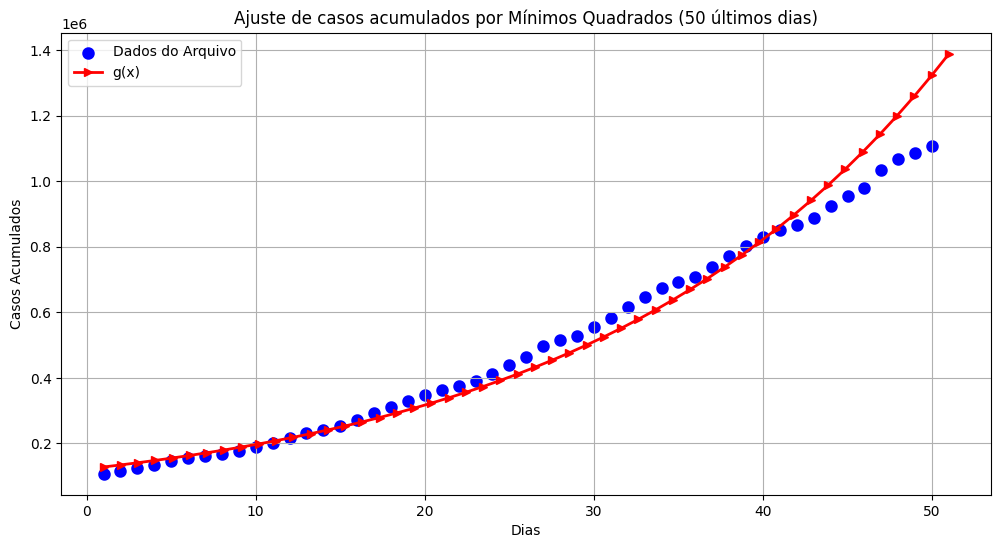

In [138]:
def mmq(x, y, k):
    X = np.vander(x, k)
    A = np.transpose(X).dot(X)
    b = np.transpose(X).dot(y)
    a = np.linalg.solve(A, b)
    return a

# Dados de casos acumulados
data = np.loadtxt('/content/casosacumuladosbrasilatuaizado.txt')
x = np.arange(1, 51)  # Apenas os 50 últimos dias
y = data[-50:]  # Apenas os 50 últimos valores

# Ajuste dos dados usando a função g(x) = ab^x
a = mmq(x, np.log(y), 2)

g = lambda x: np.exp(a[1]) * np.exp(a[0])**x

x_cont = np.linspace(1, 51, num=50, endpoint=True)

# Plot dos dados e da função ajustada
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Dados do Arquivo', linewidth=3, color='blue')
plt.plot(x_cont, g(x_cont), label='g(x)', linewidth=2, marker='>', color='red')
plt.xlabel('Dias')
plt.ylabel('Casos Acumulados')
plt.title('Ajuste de casos acumulados por Mínimos Quadrados (50 últimos dias)')
plt.legend()
plt.grid(True)
plt.show()

**e)** Compare os ítens b), c) e d). Que tipo de informação os dados nos fornecem?

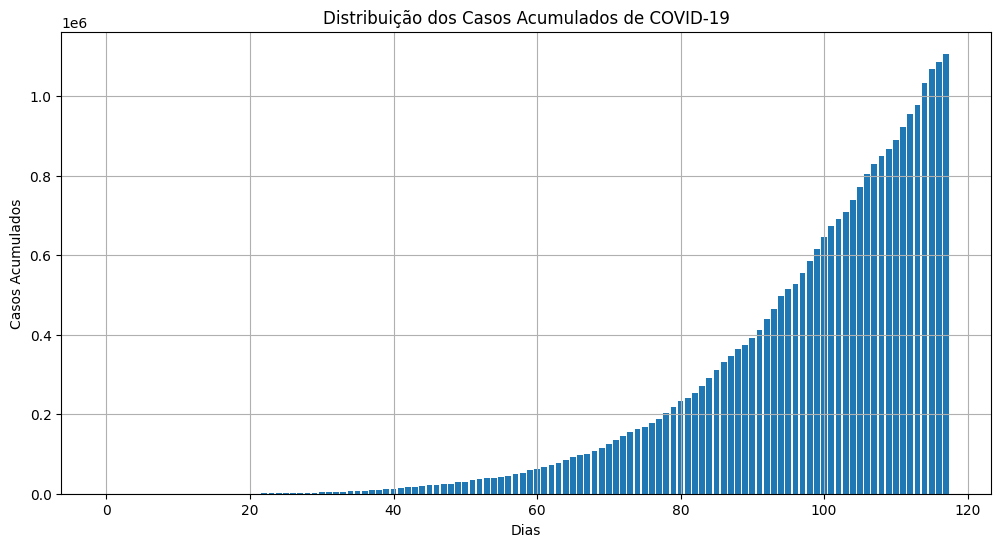

In [139]:
# Verificando a distribuição dos casos acumulados de COVID-19

x = np.arange(len(data))  # Índices dos dias
y = data

# Distribuição dos casos
plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.xlabel('Dias')
plt.ylabel('Casos Acumulados')
plt.title('Distribuição dos Casos Acumulados de COVID-19')
plt.grid(True)
plt.show()

## **Conclusão**

A função sugerida inicialmente foi a função exponencial, devido ao comportamento crescente do número de casos de Covid-19 nos primeiros 118 dias. Porém, ao analisar separadamente os itens c) e d) chegamos à conclusão que embora a distribuição dos dados pareça com uma distribuição exponencial, o gráfico do item d) sugere uma suavização ou decaimento do número de casos, isso pode ocorrer quando há perda de dados, ou não notificação de novos casos, além de medidas de controle como o lockdown, por exemplo. Devido à esses fatores, o modelo exponencial não é adequado pois não é possível afirmar com exatidão que os dados terão esse comportamento. No primeiro gráfico do item b) é perceptível a considerável margem de erro dos dados originais e da função suposta.